# Lie Detection CNN Training

In [1]:
# Imports
import numpy as np
import pandas as pd 
import os
from utils.stressutilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [3]:
G1_train = pd.read_csv("./stressdata/train/Inertial_Signals/X_train.csv",header = None)
labels_train = pd.read_csv("./stressdata/train/Y_train.txt",header = None)
n_channels = 1
n_steps = 352
X_train = np.zeros((len(labels_train),n_steps,n_channels))
X_train[:,:,0] = G1_train.as_matrix()

G1_test = pd.read_csv("./stressdata/test/Inertial_Signals/X_test.csv",header = None)
labels_test = pd.read_csv("./stressdata/test/Y_test.txt",header = None)
X_test = np.zeros((len(labels_test),n_steps,n_channels))
X_test[:,:,0] = G1_test.as_matrix()
print(X_train.shape)
print(X_test.shape)
print(labels_train.shape)
print(labels_test.shape)
print(labels_train[0].values.shape)

(27803, 352, 1)
(6951, 352, 1)
(27803, 1)
(6951, 1)
(27803,)


In [4]:
# Normalize
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [5]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train[0].values, 
                                                stratify = labels_train[0].values, random_state = 123)
print(X_tr.shape)
print(lab_tr.shape)    # 75%
print(X_vld.shape)
print(lab_vld.shape)   # 25%

(20852, 352, 1)
(20852,)
(6951, 352, 1)
(6951,)


One-hot encoding:

In [6]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test[0].values)

In [7]:
# Imports
import tensorflow as tf

### Hyperparameters

In [14]:
batch_size = 100       # Batch size
seq_len = 352          # Number of steps
learning_rate = 0.001
epochs = 100

n_classes = 2
n_channels = 1

### Construct the graph
Placeholders

In [15]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [16]:
with graph.as_default():
    # (batch, 352, 1) --> (batch, 22, 16)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=16, kernel_size=16, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=16, strides=16, padding='same')
    
  #  # (batch, 250, 4) --> (batch, 125, 8)
  #  conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=8, kernel_size=2, strides=1, 
  #                           padding='same', activation = tf.nn.relu) 
  #  max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
  #  # (batch, 50, 20) --> (batch, 5, 200)
  #  conv3 = tf.layers.conv1d(inputs=max_pool_1, filters=200, kernel_size=10, strides=1, 
  #                           padding='same', activation = tf.nn.tanh)
  #  max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=10, strides=10, padding='same')
    
  #  # (batch, 25, 40) --> (batch, 5, 200)
  #  conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=200, kernel_size=5, strides=1, 
  #                           padding='same', activation = tf.nn.relu)
  #  max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=5, strides=5, padding='same')

Now, flatten and pass to the classifier

In [17]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_1, (-1, 22*16))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
    # Recall and precision
    #recall = tf.metrics.recall(tf.argmax(labels_, 1),tf.argmax(logits, 1))
    #precision = tf.metrics.precision(tf.argmax(labels_, 1),tf.argmax(logits, 1))
    

### Train the network

In [18]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [20]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, 200):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            #train_recall.append(recall)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, 200):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                   # val_recall_.append(recall_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
             #   validation_recall.append(np.mean(val_recall_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/100 Iteration: 5 Train loss: 1.224755 Train acc: 0.295000
Epoch: 0/100 Iteration: 10 Train loss: 0.649479 Train acc: 0.755000
Epoch: 0/100 Iteration: 10 Validation loss: 0.528268 Validation acc: 0.832500
Epoch: 0/100 Iteration: 15 Train loss: 0.619493 Train acc: 0.805000
Epoch: 0/100 Iteration: 20 Train loss: 0.574312 Train acc: 0.835000
Epoch: 0/100 Iteration: 20 Validation loss: 0.630642 Validation acc: 0.832647
Epoch: 0/100 Iteration: 25 Train loss: 0.645657 Train acc: 0.830000
Epoch: 0/100 Iteration: 30 Train loss: 0.665358 Train acc: 0.785000
Epoch: 0/100 Iteration: 30 Validation loss: 0.547171 Validation acc: 0.832647
Epoch: 0/100 Iteration: 35 Train loss: 0.504250 Train acc: 0.830000
Epoch: 0/100 Iteration: 40 Train loss: 0.530490 Train acc: 0.785000
Epoch: 0/100 Iteration: 40 Validation loss: 0.456493 Validation acc: 0.832647
Epoch: 0/100 Iteration: 45 Train loss: 0.471019 Train acc: 0.805000
Epoch: 0/100 Iteration: 50 Train loss: 0.553236 Train acc: 0.795000
Epoch: 0/

Epoch: 3/100 Iteration: 390 Train loss: 0.172048 Train acc: 0.960000
Epoch: 3/100 Iteration: 390 Validation loss: 0.191358 Validation acc: 0.911176
Epoch: 3/100 Iteration: 395 Train loss: 0.196276 Train acc: 0.935000
Epoch: 3/100 Iteration: 400 Train loss: 0.232564 Train acc: 0.895000
Epoch: 3/100 Iteration: 400 Validation loss: 0.189915 Validation acc: 0.910735
Epoch: 3/100 Iteration: 405 Train loss: 0.201820 Train acc: 0.895000
Epoch: 3/100 Iteration: 410 Train loss: 0.327214 Train acc: 0.860000
Epoch: 3/100 Iteration: 410 Validation loss: 0.185841 Validation acc: 0.915294
Epoch: 3/100 Iteration: 415 Train loss: 0.229500 Train acc: 0.910000
Epoch: 4/100 Iteration: 420 Train loss: 0.192341 Train acc: 0.955000
Epoch: 4/100 Iteration: 420 Validation loss: 0.181571 Validation acc: 0.923382
Epoch: 4/100 Iteration: 425 Train loss: 0.275896 Train acc: 0.875000
Epoch: 4/100 Iteration: 430 Train loss: 0.239593 Train acc: 0.900000
Epoch: 4/100 Iteration: 430 Validation loss: 0.180571 Validatio

Epoch: 7/100 Iteration: 770 Train loss: 0.131075 Train acc: 0.945000
Epoch: 7/100 Iteration: 770 Validation loss: 0.116068 Validation acc: 0.961029
Epoch: 7/100 Iteration: 775 Train loss: 0.117984 Train acc: 0.950000
Epoch: 7/100 Iteration: 780 Train loss: 0.190409 Train acc: 0.935000
Epoch: 7/100 Iteration: 780 Validation loss: 0.117819 Validation acc: 0.956029
Epoch: 7/100 Iteration: 785 Train loss: 0.171212 Train acc: 0.925000
Epoch: 7/100 Iteration: 790 Train loss: 0.185385 Train acc: 0.955000
Epoch: 7/100 Iteration: 790 Validation loss: 0.114628 Validation acc: 0.959853
Epoch: 7/100 Iteration: 795 Train loss: 0.156957 Train acc: 0.940000
Epoch: 7/100 Iteration: 800 Train loss: 0.138585 Train acc: 0.955000
Epoch: 7/100 Iteration: 800 Validation loss: 0.112461 Validation acc: 0.962059
Epoch: 7/100 Iteration: 805 Train loss: 0.164355 Train acc: 0.920000
Epoch: 7/100 Iteration: 810 Train loss: 0.131261 Train acc: 0.955000
Epoch: 7/100 Iteration: 810 Validation loss: 0.111020 Validatio

Epoch: 11/100 Iteration: 1150 Train loss: 0.183884 Train acc: 0.930000
Epoch: 11/100 Iteration: 1150 Validation loss: 0.084532 Validation acc: 0.978382
Epoch: 11/100 Iteration: 1155 Train loss: 0.097357 Train acc: 0.955000
Epoch: 11/100 Iteration: 1160 Train loss: 0.130264 Train acc: 0.940000
Epoch: 11/100 Iteration: 1160 Validation loss: 0.087867 Validation acc: 0.971030
Epoch: 11/100 Iteration: 1165 Train loss: 0.079830 Train acc: 0.980000
Epoch: 11/100 Iteration: 1170 Train loss: 0.122727 Train acc: 0.965000
Epoch: 11/100 Iteration: 1170 Validation loss: 0.087030 Validation acc: 0.972353
Epoch: 11/100 Iteration: 1175 Train loss: 0.116265 Train acc: 0.960000
Epoch: 11/100 Iteration: 1180 Train loss: 0.160290 Train acc: 0.935000
Epoch: 11/100 Iteration: 1180 Validation loss: 0.084580 Validation acc: 0.976029
Epoch: 11/100 Iteration: 1185 Train loss: 0.193364 Train acc: 0.940000
Epoch: 11/100 Iteration: 1190 Train loss: 0.110306 Train acc: 0.955000
Epoch: 11/100 Iteration: 1190 Validat

Epoch: 14/100 Iteration: 1520 Train loss: 0.109309 Train acc: 0.965000
Epoch: 14/100 Iteration: 1520 Validation loss: 0.073346 Validation acc: 0.977500
Epoch: 14/100 Iteration: 1525 Train loss: 0.103676 Train acc: 0.965000
Epoch: 14/100 Iteration: 1530 Train loss: 0.176474 Train acc: 0.935000
Epoch: 14/100 Iteration: 1530 Validation loss: 0.069651 Validation acc: 0.981176
Epoch: 14/100 Iteration: 1535 Train loss: 0.098555 Train acc: 0.955000
Epoch: 14/100 Iteration: 1540 Train loss: 0.155070 Train acc: 0.960000
Epoch: 14/100 Iteration: 1540 Validation loss: 0.070932 Validation acc: 0.979265
Epoch: 14/100 Iteration: 1545 Train loss: 0.152834 Train acc: 0.960000
Epoch: 14/100 Iteration: 1550 Train loss: 0.096115 Train acc: 0.970000
Epoch: 14/100 Iteration: 1550 Validation loss: 0.068496 Validation acc: 0.983088
Epoch: 14/100 Iteration: 1555 Train loss: 0.117370 Train acc: 0.970000
Epoch: 14/100 Iteration: 1560 Train loss: 0.133450 Train acc: 0.955000
Epoch: 14/100 Iteration: 1560 Validat

Epoch: 18/100 Iteration: 1890 Train loss: 0.138730 Train acc: 0.955000
Epoch: 18/100 Iteration: 1890 Validation loss: 0.061573 Validation acc: 0.982794
Epoch: 18/100 Iteration: 1895 Train loss: 0.141094 Train acc: 0.955000
Epoch: 18/100 Iteration: 1900 Train loss: 0.096692 Train acc: 0.965000
Epoch: 18/100 Iteration: 1900 Validation loss: 0.057814 Validation acc: 0.985441
Epoch: 18/100 Iteration: 1905 Train loss: 0.165771 Train acc: 0.935000
Epoch: 18/100 Iteration: 1910 Train loss: 0.076528 Train acc: 0.980000
Epoch: 18/100 Iteration: 1910 Validation loss: 0.057968 Validation acc: 0.986029
Epoch: 18/100 Iteration: 1915 Train loss: 0.078106 Train acc: 0.975000
Epoch: 18/100 Iteration: 1920 Train loss: 0.056820 Train acc: 0.995000
Epoch: 18/100 Iteration: 1920 Validation loss: 0.060425 Validation acc: 0.982500
Epoch: 18/100 Iteration: 1925 Train loss: 0.078560 Train acc: 0.970000
Epoch: 18/100 Iteration: 1930 Train loss: 0.122583 Train acc: 0.950000
Epoch: 18/100 Iteration: 1930 Validat

Epoch: 21/100 Iteration: 2260 Train loss: 0.086514 Train acc: 0.970000
Epoch: 21/100 Iteration: 2260 Validation loss: 0.051849 Validation acc: 0.987206
Epoch: 21/100 Iteration: 2265 Train loss: 0.101686 Train acc: 0.975000
Epoch: 21/100 Iteration: 2270 Train loss: 0.189583 Train acc: 0.930000
Epoch: 21/100 Iteration: 2270 Validation loss: 0.053828 Validation acc: 0.985441
Epoch: 21/100 Iteration: 2275 Train loss: 0.091714 Train acc: 0.960000
Epoch: 21/100 Iteration: 2280 Train loss: 0.093322 Train acc: 0.970000
Epoch: 21/100 Iteration: 2280 Validation loss: 0.052593 Validation acc: 0.986765
Epoch: 21/100 Iteration: 2285 Train loss: 0.170150 Train acc: 0.940000
Epoch: 22/100 Iteration: 2290 Train loss: 0.079122 Train acc: 0.980000
Epoch: 22/100 Iteration: 2290 Validation loss: 0.052283 Validation acc: 0.986912
Epoch: 22/100 Iteration: 2295 Train loss: 0.110720 Train acc: 0.960000
Epoch: 22/100 Iteration: 2300 Train loss: 0.087164 Train acc: 0.985000
Epoch: 22/100 Iteration: 2300 Validat

Epoch: 25/100 Iteration: 2630 Train loss: 0.083346 Train acc: 0.955000
Epoch: 25/100 Iteration: 2630 Validation loss: 0.047006 Validation acc: 0.987941
Epoch: 25/100 Iteration: 2635 Train loss: 0.069932 Train acc: 0.975000
Epoch: 25/100 Iteration: 2640 Train loss: 0.111254 Train acc: 0.970000
Epoch: 25/100 Iteration: 2640 Validation loss: 0.049857 Validation acc: 0.986618
Epoch: 25/100 Iteration: 2645 Train loss: 0.073988 Train acc: 0.975000
Epoch: 25/100 Iteration: 2650 Train loss: 0.093682 Train acc: 0.975000
Epoch: 25/100 Iteration: 2650 Validation loss: 0.048685 Validation acc: 0.987500
Epoch: 25/100 Iteration: 2655 Train loss: 0.082398 Train acc: 0.955000
Epoch: 25/100 Iteration: 2660 Train loss: 0.078731 Train acc: 0.970000
Epoch: 25/100 Iteration: 2660 Validation loss: 0.046801 Validation acc: 0.988676
Epoch: 25/100 Iteration: 2665 Train loss: 0.101991 Train acc: 0.960000
Epoch: 25/100 Iteration: 2670 Train loss: 0.117009 Train acc: 0.950000
Epoch: 25/100 Iteration: 2670 Validat

Epoch: 28/100 Iteration: 3000 Train loss: 0.108669 Train acc: 0.970000
Epoch: 28/100 Iteration: 3000 Validation loss: 0.047958 Validation acc: 0.986618
Epoch: 28/100 Iteration: 3005 Train loss: 0.070739 Train acc: 0.970000
Epoch: 28/100 Iteration: 3010 Train loss: 0.117126 Train acc: 0.955000
Epoch: 28/100 Iteration: 3010 Validation loss: 0.043706 Validation acc: 0.988823
Epoch: 28/100 Iteration: 3015 Train loss: 0.080063 Train acc: 0.980000
Epoch: 29/100 Iteration: 3020 Train loss: 0.044194 Train acc: 0.985000
Epoch: 29/100 Iteration: 3020 Validation loss: 0.042880 Validation acc: 0.989559
Epoch: 29/100 Iteration: 3025 Train loss: 0.075587 Train acc: 0.975000
Epoch: 29/100 Iteration: 3030 Train loss: 0.095359 Train acc: 0.960000
Epoch: 29/100 Iteration: 3030 Validation loss: 0.045105 Validation acc: 0.988529
Epoch: 29/100 Iteration: 3035 Train loss: 0.098026 Train acc: 0.960000
Epoch: 29/100 Iteration: 3040 Train loss: 0.061571 Train acc: 0.985000
Epoch: 29/100 Iteration: 3040 Validat

Epoch: 32/100 Iteration: 3370 Train loss: 0.059301 Train acc: 0.985000
Epoch: 32/100 Iteration: 3370 Validation loss: 0.042787 Validation acc: 0.988971
Epoch: 32/100 Iteration: 3375 Train loss: 0.037123 Train acc: 0.990000
Epoch: 32/100 Iteration: 3380 Train loss: 0.084249 Train acc: 0.980000
Epoch: 32/100 Iteration: 3380 Validation loss: 0.044496 Validation acc: 0.988088
Epoch: 32/100 Iteration: 3385 Train loss: 0.121119 Train acc: 0.960000
Epoch: 32/100 Iteration: 3390 Train loss: 0.078844 Train acc: 0.975000
Epoch: 32/100 Iteration: 3390 Validation loss: 0.040327 Validation acc: 0.990147
Epoch: 32/100 Iteration: 3395 Train loss: 0.093836 Train acc: 0.955000
Epoch: 32/100 Iteration: 3400 Train loss: 0.071176 Train acc: 0.970000
Epoch: 32/100 Iteration: 3400 Validation loss: 0.040603 Validation acc: 0.989853
Epoch: 32/100 Iteration: 3405 Train loss: 0.110775 Train acc: 0.960000
Epoch: 32/100 Iteration: 3410 Train loss: 0.051074 Train acc: 0.990000
Epoch: 32/100 Iteration: 3410 Validat

Epoch: 35/100 Iteration: 3740 Train loss: 0.094978 Train acc: 0.975000
Epoch: 35/100 Iteration: 3740 Validation loss: 0.039646 Validation acc: 0.990735
Epoch: 36/100 Iteration: 3745 Train loss: 0.104749 Train acc: 0.975000
Epoch: 36/100 Iteration: 3750 Train loss: 0.087923 Train acc: 0.975000
Epoch: 36/100 Iteration: 3750 Validation loss: 0.039618 Validation acc: 0.990000
Epoch: 36/100 Iteration: 3755 Train loss: 0.049883 Train acc: 0.975000
Epoch: 36/100 Iteration: 3760 Train loss: 0.109185 Train acc: 0.975000
Epoch: 36/100 Iteration: 3760 Validation loss: 0.041623 Validation acc: 0.989118
Epoch: 36/100 Iteration: 3765 Train loss: 0.083524 Train acc: 0.970000
Epoch: 36/100 Iteration: 3770 Train loss: 0.094714 Train acc: 0.960000
Epoch: 36/100 Iteration: 3770 Validation loss: 0.039140 Validation acc: 0.990147
Epoch: 36/100 Iteration: 3775 Train loss: 0.091118 Train acc: 0.980000
Epoch: 36/100 Iteration: 3780 Train loss: 0.055691 Train acc: 0.985000
Epoch: 36/100 Iteration: 3780 Validat

Epoch: 39/100 Iteration: 4110 Train loss: 0.079024 Train acc: 0.975000
Epoch: 39/100 Iteration: 4110 Validation loss: 0.039642 Validation acc: 0.989853
Epoch: 39/100 Iteration: 4115 Train loss: 0.083229 Train acc: 0.980000
Epoch: 39/100 Iteration: 4120 Train loss: 0.100861 Train acc: 0.970000
Epoch: 39/100 Iteration: 4120 Validation loss: 0.038359 Validation acc: 0.989853
Epoch: 39/100 Iteration: 4125 Train loss: 0.053726 Train acc: 0.985000
Epoch: 39/100 Iteration: 4130 Train loss: 0.122764 Train acc: 0.950000
Epoch: 39/100 Iteration: 4130 Validation loss: 0.037602 Validation acc: 0.990441
Epoch: 39/100 Iteration: 4135 Train loss: 0.060782 Train acc: 0.985000
Epoch: 39/100 Iteration: 4140 Train loss: 0.078061 Train acc: 0.970000
Epoch: 39/100 Iteration: 4140 Validation loss: 0.038808 Validation acc: 0.989853
Epoch: 39/100 Iteration: 4145 Train loss: 0.070284 Train acc: 0.975000
Epoch: 39/100 Iteration: 4150 Train loss: 0.042551 Train acc: 0.980000
Epoch: 39/100 Iteration: 4150 Validat

Epoch: 43/100 Iteration: 4480 Train loss: 0.124337 Train acc: 0.950000
Epoch: 43/100 Iteration: 4480 Validation loss: 0.037640 Validation acc: 0.990735
Epoch: 43/100 Iteration: 4485 Train loss: 0.113653 Train acc: 0.965000
Epoch: 43/100 Iteration: 4490 Train loss: 0.139150 Train acc: 0.965000
Epoch: 43/100 Iteration: 4490 Validation loss: 0.041201 Validation acc: 0.988823
Epoch: 43/100 Iteration: 4495 Train loss: 0.056392 Train acc: 0.970000
Epoch: 43/100 Iteration: 4500 Train loss: 0.072836 Train acc: 0.975000
Epoch: 43/100 Iteration: 4500 Validation loss: 0.038298 Validation acc: 0.991176
Epoch: 43/100 Iteration: 4505 Train loss: 0.088951 Train acc: 0.965000
Epoch: 43/100 Iteration: 4510 Train loss: 0.091417 Train acc: 0.970000
Epoch: 43/100 Iteration: 4510 Validation loss: 0.037596 Validation acc: 0.990441
Epoch: 43/100 Iteration: 4515 Train loss: 0.099234 Train acc: 0.955000
Epoch: 43/100 Iteration: 4520 Train loss: 0.063543 Train acc: 0.980000
Epoch: 43/100 Iteration: 4520 Validat

Epoch: 46/100 Iteration: 4850 Train loss: 0.041805 Train acc: 0.990000
Epoch: 46/100 Iteration: 4850 Validation loss: 0.035848 Validation acc: 0.991471
Epoch: 46/100 Iteration: 4855 Train loss: 0.069060 Train acc: 0.975000
Epoch: 46/100 Iteration: 4860 Train loss: 0.085325 Train acc: 0.965000
Epoch: 46/100 Iteration: 4860 Validation loss: 0.036096 Validation acc: 0.991029
Epoch: 46/100 Iteration: 4865 Train loss: 0.091412 Train acc: 0.960000
Epoch: 46/100 Iteration: 4870 Train loss: 0.140347 Train acc: 0.970000
Epoch: 46/100 Iteration: 4870 Validation loss: 0.039092 Validation acc: 0.988529
Epoch: 46/100 Iteration: 4875 Train loss: 0.115836 Train acc: 0.950000
Epoch: 46/100 Iteration: 4880 Train loss: 0.067205 Train acc: 0.975000
Epoch: 46/100 Iteration: 4880 Validation loss: 0.034939 Validation acc: 0.992647
Epoch: 46/100 Iteration: 4885 Train loss: 0.146391 Train acc: 0.945000
Epoch: 47/100 Iteration: 4890 Train loss: 0.079633 Train acc: 0.975000
Epoch: 47/100 Iteration: 4890 Validat

Epoch: 50/100 Iteration: 5220 Train loss: 0.107837 Train acc: 0.960000
Epoch: 50/100 Iteration: 5220 Validation loss: 0.036144 Validation acc: 0.990882
Epoch: 50/100 Iteration: 5225 Train loss: 0.056785 Train acc: 0.980000
Epoch: 50/100 Iteration: 5230 Train loss: 0.068612 Train acc: 0.975000
Epoch: 50/100 Iteration: 5230 Validation loss: 0.033673 Validation acc: 0.992353
Epoch: 50/100 Iteration: 5235 Train loss: 0.109011 Train acc: 0.955000
Epoch: 50/100 Iteration: 5240 Train loss: 0.076155 Train acc: 0.980000
Epoch: 50/100 Iteration: 5240 Validation loss: 0.033336 Validation acc: 0.992500
Epoch: 50/100 Iteration: 5245 Train loss: 0.063304 Train acc: 0.975000
Epoch: 50/100 Iteration: 5250 Train loss: 0.090512 Train acc: 0.980000
Epoch: 50/100 Iteration: 5250 Validation loss: 0.037614 Validation acc: 0.990000
Epoch: 50/100 Iteration: 5255 Train loss: 0.154754 Train acc: 0.980000
Epoch: 50/100 Iteration: 5260 Train loss: 0.029203 Train acc: 1.000000
Epoch: 50/100 Iteration: 5260 Validat

Epoch: 53/100 Iteration: 5590 Train loss: 0.044172 Train acc: 0.985000
Epoch: 53/100 Iteration: 5590 Validation loss: 0.036728 Validation acc: 0.990000
Epoch: 53/100 Iteration: 5595 Train loss: 0.054425 Train acc: 0.975000
Epoch: 53/100 Iteration: 5600 Train loss: 0.084613 Train acc: 0.965000
Epoch: 53/100 Iteration: 5600 Validation loss: 0.034425 Validation acc: 0.991618
Epoch: 53/100 Iteration: 5605 Train loss: 0.055028 Train acc: 0.985000
Epoch: 53/100 Iteration: 5610 Train loss: 0.066695 Train acc: 0.985000
Epoch: 53/100 Iteration: 5610 Validation loss: 0.033345 Validation acc: 0.992794
Epoch: 53/100 Iteration: 5615 Train loss: 0.074976 Train acc: 0.965000
Epoch: 54/100 Iteration: 5620 Train loss: 0.020714 Train acc: 0.995000
Epoch: 54/100 Iteration: 5620 Validation loss: 0.034787 Validation acc: 0.990882
Epoch: 54/100 Iteration: 5625 Train loss: 0.070257 Train acc: 0.975000
Epoch: 54/100 Iteration: 5630 Train loss: 0.077507 Train acc: 0.970000
Epoch: 54/100 Iteration: 5630 Validat

Epoch: 57/100 Iteration: 5960 Train loss: 0.036594 Train acc: 0.980000
Epoch: 57/100 Iteration: 5960 Validation loss: 0.034421 Validation acc: 0.991765
Epoch: 57/100 Iteration: 5965 Train loss: 0.088328 Train acc: 0.970000
Epoch: 57/100 Iteration: 5970 Train loss: 0.025001 Train acc: 1.000000
Epoch: 57/100 Iteration: 5970 Validation loss: 0.033320 Validation acc: 0.992647
Epoch: 57/100 Iteration: 5975 Train loss: 0.062869 Train acc: 0.980000
Epoch: 57/100 Iteration: 5980 Train loss: 0.055213 Train acc: 0.975000
Epoch: 57/100 Iteration: 5980 Validation loss: 0.037282 Validation acc: 0.990000
Epoch: 57/100 Iteration: 5985 Train loss: 0.069462 Train acc: 0.975000
Epoch: 57/100 Iteration: 5990 Train loss: 0.065406 Train acc: 0.985000
Epoch: 57/100 Iteration: 5990 Validation loss: 0.035170 Validation acc: 0.990735
Epoch: 57/100 Iteration: 5995 Train loss: 0.037394 Train acc: 0.990000
Epoch: 57/100 Iteration: 6000 Train loss: 0.069066 Train acc: 0.980000
Epoch: 57/100 Iteration: 6000 Validat

Epoch: 60/100 Iteration: 6330 Train loss: 0.067562 Train acc: 0.980000
Epoch: 60/100 Iteration: 6330 Validation loss: 0.033169 Validation acc: 0.991618
Epoch: 60/100 Iteration: 6335 Train loss: 0.081498 Train acc: 0.970000
Epoch: 60/100 Iteration: 6340 Train loss: 0.068150 Train acc: 0.970000
Epoch: 60/100 Iteration: 6340 Validation loss: 0.033045 Validation acc: 0.991618
Epoch: 61/100 Iteration: 6345 Train loss: 0.097309 Train acc: 0.970000
Epoch: 61/100 Iteration: 6350 Train loss: 0.144961 Train acc: 0.965000
Epoch: 61/100 Iteration: 6350 Validation loss: 0.033993 Validation acc: 0.991471
Epoch: 61/100 Iteration: 6355 Train loss: 0.080191 Train acc: 0.975000
Epoch: 61/100 Iteration: 6360 Train loss: 0.086431 Train acc: 0.975000
Epoch: 61/100 Iteration: 6360 Validation loss: 0.034286 Validation acc: 0.990735
Epoch: 61/100 Iteration: 6365 Train loss: 0.048709 Train acc: 0.985000
Epoch: 61/100 Iteration: 6370 Train loss: 0.050712 Train acc: 0.990000
Epoch: 61/100 Iteration: 6370 Validat

Epoch: 64/100 Iteration: 6700 Train loss: 0.088447 Train acc: 0.960000
Epoch: 64/100 Iteration: 6700 Validation loss: 0.032164 Validation acc: 0.992353
Epoch: 64/100 Iteration: 6705 Train loss: 0.089230 Train acc: 0.975000
Epoch: 64/100 Iteration: 6710 Train loss: 0.135968 Train acc: 0.965000
Epoch: 64/100 Iteration: 6710 Validation loss: 0.033859 Validation acc: 0.991471
Epoch: 64/100 Iteration: 6715 Train loss: 0.110414 Train acc: 0.960000
Epoch: 64/100 Iteration: 6720 Train loss: 0.055732 Train acc: 0.980000
Epoch: 64/100 Iteration: 6720 Validation loss: 0.033937 Validation acc: 0.991324
Epoch: 64/100 Iteration: 6725 Train loss: 0.036086 Train acc: 0.990000
Epoch: 64/100 Iteration: 6730 Train loss: 0.057310 Train acc: 0.985000
Epoch: 64/100 Iteration: 6730 Validation loss: 0.034147 Validation acc: 0.990735
Epoch: 64/100 Iteration: 6735 Train loss: 0.128124 Train acc: 0.970000
Epoch: 64/100 Iteration: 6740 Train loss: 0.065037 Train acc: 0.970000
Epoch: 64/100 Iteration: 6740 Validat

Epoch: 67/100 Iteration: 7070 Train loss: 0.065066 Train acc: 0.990000
Epoch: 67/100 Iteration: 7070 Validation loss: 0.031354 Validation acc: 0.993088
Epoch: 68/100 Iteration: 7075 Train loss: 0.107556 Train acc: 0.975000
Epoch: 68/100 Iteration: 7080 Train loss: 0.069023 Train acc: 0.975000
Epoch: 68/100 Iteration: 7080 Validation loss: 0.032475 Validation acc: 0.992059
Epoch: 68/100 Iteration: 7085 Train loss: 0.096063 Train acc: 0.965000
Epoch: 68/100 Iteration: 7090 Train loss: 0.099143 Train acc: 0.960000
Epoch: 68/100 Iteration: 7090 Validation loss: 0.034411 Validation acc: 0.990294
Epoch: 68/100 Iteration: 7095 Train loss: 0.075518 Train acc: 0.985000
Epoch: 68/100 Iteration: 7100 Train loss: 0.066878 Train acc: 0.970000
Epoch: 68/100 Iteration: 7100 Validation loss: 0.031872 Validation acc: 0.993088
Epoch: 68/100 Iteration: 7105 Train loss: 0.059575 Train acc: 0.980000
Epoch: 68/100 Iteration: 7110 Train loss: 0.082214 Train acc: 0.975000
Epoch: 68/100 Iteration: 7110 Validat

Epoch: 71/100 Iteration: 7440 Train loss: 0.068067 Train acc: 0.970000
Epoch: 71/100 Iteration: 7440 Validation loss: 0.034197 Validation acc: 0.991030
Epoch: 71/100 Iteration: 7445 Train loss: 0.056278 Train acc: 0.975000
Epoch: 71/100 Iteration: 7450 Train loss: 0.046281 Train acc: 0.985000
Epoch: 71/100 Iteration: 7450 Validation loss: 0.033332 Validation acc: 0.991176
Epoch: 71/100 Iteration: 7455 Train loss: 0.087163 Train acc: 0.970000
Epoch: 71/100 Iteration: 7460 Train loss: 0.081129 Train acc: 0.980000
Epoch: 71/100 Iteration: 7460 Validation loss: 0.031266 Validation acc: 0.992206
Epoch: 71/100 Iteration: 7465 Train loss: 0.068025 Train acc: 0.980000
Epoch: 71/100 Iteration: 7470 Train loss: 0.058962 Train acc: 0.985000
Epoch: 71/100 Iteration: 7470 Validation loss: 0.030873 Validation acc: 0.992500
Epoch: 71/100 Iteration: 7475 Train loss: 0.076667 Train acc: 0.955000
Epoch: 71/100 Iteration: 7480 Train loss: 0.083748 Train acc: 0.970000
Epoch: 71/100 Iteration: 7480 Validat

Epoch: 75/100 Iteration: 7810 Train loss: 0.067066 Train acc: 0.985000
Epoch: 75/100 Iteration: 7810 Validation loss: 0.031961 Validation acc: 0.991324
Epoch: 75/100 Iteration: 7815 Train loss: 0.075593 Train acc: 0.965000
Epoch: 75/100 Iteration: 7820 Train loss: 0.072151 Train acc: 0.975000
Epoch: 75/100 Iteration: 7820 Validation loss: 0.031013 Validation acc: 0.991765
Epoch: 75/100 Iteration: 7825 Train loss: 0.061282 Train acc: 0.985000
Epoch: 75/100 Iteration: 7830 Train loss: 0.046528 Train acc: 0.990000
Epoch: 75/100 Iteration: 7830 Validation loss: 0.030967 Validation acc: 0.991765
Epoch: 75/100 Iteration: 7835 Train loss: 0.049296 Train acc: 0.990000
Epoch: 75/100 Iteration: 7840 Train loss: 0.054779 Train acc: 0.980000
Epoch: 75/100 Iteration: 7840 Validation loss: 0.031197 Validation acc: 0.992059
Epoch: 75/100 Iteration: 7845 Train loss: 0.097810 Train acc: 0.970000
Epoch: 75/100 Iteration: 7850 Train loss: 0.052495 Train acc: 0.985000
Epoch: 75/100 Iteration: 7850 Validat

Epoch: 78/100 Iteration: 8180 Train loss: 0.074093 Train acc: 0.975000
Epoch: 78/100 Iteration: 8180 Validation loss: 0.029564 Validation acc: 0.992500
Epoch: 78/100 Iteration: 8185 Train loss: 0.068335 Train acc: 0.970000
Epoch: 78/100 Iteration: 8190 Train loss: 0.038046 Train acc: 0.990000
Epoch: 78/100 Iteration: 8190 Validation loss: 0.030206 Validation acc: 0.992353
Epoch: 78/100 Iteration: 8195 Train loss: 0.026583 Train acc: 0.990000
Epoch: 78/100 Iteration: 8200 Train loss: 0.041105 Train acc: 0.985000
Epoch: 78/100 Iteration: 8200 Validation loss: 0.032854 Validation acc: 0.991765
Epoch: 78/100 Iteration: 8205 Train loss: 0.078579 Train acc: 0.960000
Epoch: 78/100 Iteration: 8210 Train loss: 0.081883 Train acc: 0.970000
Epoch: 78/100 Iteration: 8210 Validation loss: 0.029975 Validation acc: 0.992794
Epoch: 78/100 Iteration: 8215 Train loss: 0.062026 Train acc: 0.975000
Epoch: 79/100 Iteration: 8220 Train loss: 0.060121 Train acc: 0.980000
Epoch: 79/100 Iteration: 8220 Validat

Epoch: 82/100 Iteration: 8550 Train loss: 0.076180 Train acc: 0.980000
Epoch: 82/100 Iteration: 8550 Validation loss: 0.031326 Validation acc: 0.992353
Epoch: 82/100 Iteration: 8555 Train loss: 0.078894 Train acc: 0.970000
Epoch: 82/100 Iteration: 8560 Train loss: 0.041301 Train acc: 0.980000
Epoch: 82/100 Iteration: 8560 Validation loss: 0.029386 Validation acc: 0.993383
Epoch: 82/100 Iteration: 8565 Train loss: 0.041651 Train acc: 0.980000
Epoch: 82/100 Iteration: 8570 Train loss: 0.041699 Train acc: 0.990000
Epoch: 82/100 Iteration: 8570 Validation loss: 0.029368 Validation acc: 0.993235
Epoch: 82/100 Iteration: 8575 Train loss: 0.021899 Train acc: 0.995000
Epoch: 82/100 Iteration: 8580 Train loss: 0.056669 Train acc: 0.985000
Epoch: 82/100 Iteration: 8580 Validation loss: 0.031884 Validation acc: 0.991177
Epoch: 82/100 Iteration: 8585 Train loss: 0.062951 Train acc: 0.985000
Epoch: 82/100 Iteration: 8590 Train loss: 0.057530 Train acc: 0.980000
Epoch: 82/100 Iteration: 8590 Validat

Epoch: 85/100 Iteration: 8920 Train loss: 0.084831 Train acc: 0.970000
Epoch: 85/100 Iteration: 8920 Validation loss: 0.029160 Validation acc: 0.992206
Epoch: 85/100 Iteration: 8925 Train loss: 0.058140 Train acc: 0.975000
Epoch: 85/100 Iteration: 8930 Train loss: 0.130576 Train acc: 0.965000
Epoch: 85/100 Iteration: 8930 Validation loss: 0.029292 Validation acc: 0.992353
Epoch: 85/100 Iteration: 8935 Train loss: 0.065547 Train acc: 0.975000
Epoch: 85/100 Iteration: 8940 Train loss: 0.081245 Train acc: 0.965000
Epoch: 85/100 Iteration: 8940 Validation loss: 0.030550 Validation acc: 0.991765
Epoch: 86/100 Iteration: 8945 Train loss: 0.104696 Train acc: 0.965000
Epoch: 86/100 Iteration: 8950 Train loss: 0.082010 Train acc: 0.975000
Epoch: 86/100 Iteration: 8950 Validation loss: 0.029364 Validation acc: 0.992647
Epoch: 86/100 Iteration: 8955 Train loss: 0.104255 Train acc: 0.960000
Epoch: 86/100 Iteration: 8960 Train loss: 0.077345 Train acc: 0.975000
Epoch: 86/100 Iteration: 8960 Validat

Epoch: 89/100 Iteration: 9290 Train loss: 0.074926 Train acc: 0.980000
Epoch: 89/100 Iteration: 9290 Validation loss: 0.029332 Validation acc: 0.992059
Epoch: 89/100 Iteration: 9295 Train loss: 0.126775 Train acc: 0.965000
Epoch: 89/100 Iteration: 9300 Train loss: 0.063884 Train acc: 0.970000
Epoch: 89/100 Iteration: 9300 Validation loss: 0.029199 Validation acc: 0.992206
Epoch: 89/100 Iteration: 9305 Train loss: 0.036192 Train acc: 0.990000
Epoch: 89/100 Iteration: 9310 Train loss: 0.032640 Train acc: 0.995000
Epoch: 89/100 Iteration: 9310 Validation loss: 0.032998 Validation acc: 0.990000
Epoch: 89/100 Iteration: 9315 Train loss: 0.067038 Train acc: 0.970000
Epoch: 89/100 Iteration: 9320 Train loss: 0.127475 Train acc: 0.960000
Epoch: 89/100 Iteration: 9320 Validation loss: 0.030345 Validation acc: 0.990882
Epoch: 89/100 Iteration: 9325 Train loss: 0.069092 Train acc: 0.975000
Epoch: 89/100 Iteration: 9330 Train loss: 0.062196 Train acc: 0.970000
Epoch: 89/100 Iteration: 9330 Validat

Epoch: 92/100 Iteration: 9660 Train loss: 0.071577 Train acc: 0.955000
Epoch: 92/100 Iteration: 9660 Validation loss: 0.028242 Validation acc: 0.993383
Epoch: 92/100 Iteration: 9665 Train loss: 0.073905 Train acc: 0.980000
Epoch: 92/100 Iteration: 9670 Train loss: 0.063114 Train acc: 0.985000
Epoch: 92/100 Iteration: 9670 Validation loss: 0.027524 Validation acc: 0.993677
Epoch: 93/100 Iteration: 9675 Train loss: 0.096262 Train acc: 0.980000
Epoch: 93/100 Iteration: 9680 Train loss: 0.084817 Train acc: 0.965000
Epoch: 93/100 Iteration: 9680 Validation loss: 0.029929 Validation acc: 0.991912
Epoch: 93/100 Iteration: 9685 Train loss: 0.070957 Train acc: 0.970000
Epoch: 93/100 Iteration: 9690 Train loss: 0.088138 Train acc: 0.960000
Epoch: 93/100 Iteration: 9690 Validation loss: 0.031960 Validation acc: 0.990441
Epoch: 93/100 Iteration: 9695 Train loss: 0.044811 Train acc: 0.990000
Epoch: 93/100 Iteration: 9700 Train loss: 0.059084 Train acc: 0.975000
Epoch: 93/100 Iteration: 9700 Validat

Epoch: 96/100 Iteration: 10030 Train loss: 0.065505 Train acc: 0.975000
Epoch: 96/100 Iteration: 10030 Validation loss: 0.031902 Validation acc: 0.990588
Epoch: 96/100 Iteration: 10035 Train loss: 0.131397 Train acc: 0.965000
Epoch: 96/100 Iteration: 10040 Train loss: 0.026616 Train acc: 0.995000
Epoch: 96/100 Iteration: 10040 Validation loss: 0.030462 Validation acc: 0.991176
Epoch: 96/100 Iteration: 10045 Train loss: 0.075487 Train acc: 0.970000
Epoch: 96/100 Iteration: 10050 Train loss: 0.028363 Train acc: 1.000000
Epoch: 96/100 Iteration: 10050 Validation loss: 0.029673 Validation acc: 0.991618
Epoch: 96/100 Iteration: 10055 Train loss: 0.061112 Train acc: 0.990000
Epoch: 96/100 Iteration: 10060 Train loss: 0.048859 Train acc: 0.980000
Epoch: 96/100 Iteration: 10060 Validation loss: 0.029593 Validation acc: 0.991618
Epoch: 96/100 Iteration: 10065 Train loss: 0.033491 Train acc: 0.995000
Epoch: 96/100 Iteration: 10070 Train loss: 0.042836 Train acc: 0.990000
Epoch: 96/100 Iteration:

Epoch: 99/100 Iteration: 10390 Validation loss: 0.027705 Validation acc: 0.992794
Epoch: 99/100 Iteration: 10395 Train loss: 0.055174 Train acc: 0.985000
Epoch: 99/100 Iteration: 10400 Train loss: 0.097142 Train acc: 0.970000
Epoch: 99/100 Iteration: 10400 Validation loss: 0.027552 Validation acc: 0.993088


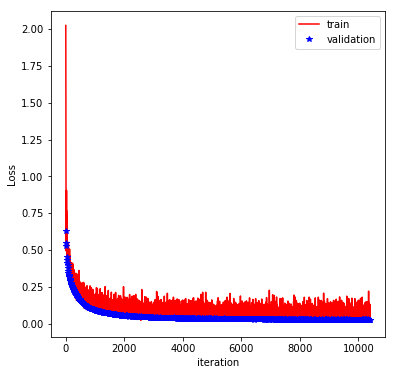

In [21]:
# Plot training and validation loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

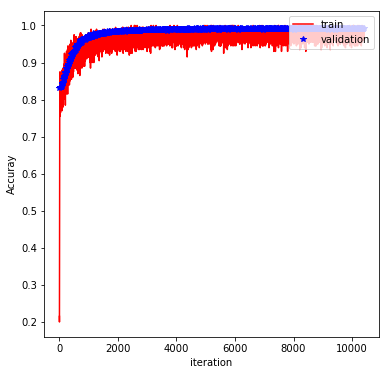

In [22]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
# Plot Recalls
#plt.figure(figsize = (6,6))

#plt.plot(t, np.array(train_recall), 'r-', t[t % 10 == 0], validation_recall, 'b*')
#plt.xlabel("iteration")
#plt.ylabel("Recall")
#plt.legend(['train', 'validation'], loc='upper right')
#plt.show()

## Evaluate on test set

In [24]:
test_acc = []
test_pred = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, 100):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_logits, batch_pred, batch_acc = sess.run([logits, correct_pred, accuracy], feed_dict=feed)
        test_acc.append(batch_acc)
        test_pred.append(batch_pred)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.991594


In [25]:
print(test_acc)
print(test_pred)
len(test_pred)

[0.99000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99000001, 0.83999997, 0.97000003, 1.0, 1.0, 1.0, 0.98000002, 0.97000003, 0.98000002, 1.0, 0.98000002, 0.93000001, 0.86000001, 0.98000002, 0.98000002, 1.0, 1.0, 1.0, 1.0, 0.99000001, 1.0, 1.0, 0.99000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  T

69

In [26]:
cm = tf.confusion_matrix(tf.argmax(y_test,1),tf.argmax(batch_logits,1))
rec, rec_op = tf.metrics.recall(tf.argmax(y_test,1),tf.argmax(batch_logits,1))
pre, pre_op = tf.metrics.precision(tf.argmax(y_test,1),tf.argmax(batch_logits,1))
tp, tp_op = tf.metrics.true_positives(tf.argmax(y_test,1),tf.argmax(batch_logits,1))
tn, tn_op = tf.metrics.true_negatives(tf.argmax(y_test,1),tf.argmax(batch_logits,1))
fp, fp_op = tf.metrics.false_positives(tf.argmax(y_test,1),tf.argmax(batch_logits,1))
fn, fn_op = tf.metrics.false_negatives(tf.argmax(y_test,1),tf.argmax(batch_logits,1))
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
tf.local_variables_initializer().run()
print(sess.run([cm,rec_op,pre_op,tp_op,tn_op,fp_op,fn_op]))

ValueError: Dimension 0 in both shapes must be equal, but are 6951 and 100. Shapes are [6951] and [100].
	From merging shape 0 with other shapes. for 'confusion_matrix/stack_2' (op: 'Pack') with input shapes: [6951], [100].

In [23]:
file = open("testfileB4Q.txt","w") 
np.savetxt("testfileB4Q.txt",batch_pred) 